USD AAI-520 - Natural Language Processing and GenAI

## Financial Agentic System

Group 5: Antonio Recalde, Ajmal Jalal, Darin Verduzco, Victor H. Germano

GitHub: https://github.com/victorhg/aai-520-final-project-group5

News sources: Yahoo Finance and NewsAPI

## Project Requirements:
Agent Functions
1. Plans its research steps for a given stock symbol.
2. Uses tools dynamically (APIs, datasets, retrieval).
3. Self-reflects to assess the quality of its output.
4. Learns across runs (e.g., keeps brief memories or notes to improve future analyses).

Workflow Patterns
1. Prompt Chaining: Ingest News → Preprocess → Classify → Extract → Summarize
2. Routing: Direct content to the right specialist (e.g., earnings, news, or market analyzers).
3. Evaluator–Optimizer: Generate analysis → evaluate quality → refine using feedback.

## Table of Contents:
1. MemoryAnalyzer - Checks if existing memory data is sufficient and fresh to answer a query.
2. Data Ingestion - Fetches financial and news data from APIs and RSS feeds; handles errors and structures data.
3. Summarizer - Generates concise summaries and routes headlines into categories based on keywords.
4. Memory Management - Stores, retrieves, and organizes summaries and relevant metadata for reuse.
5. EvaluatorOptimizer - Iteratively refines summaries for quality, consistency, and relevance.
6. Orchestrator Agent - Coordinates the workflow of all workers, routing outputs and deciding which steps to skip.
7. Run Analysis - Convenience function to execute the full orchestrator workflow and return display summary in Markdown format.

## Install requirements

In [1]:
# !pip install yfinance feedparser requests python-dotenv typing_extensions pydantic langgraph IPython langchain-openai

## Import Libraries and Environment

In [2]:
# ---------------------------
# Data Handling & I/O
# ---------------------------
import os
import json
import re
import html
import requests
import feedparser
import pandas as pd
import yfinance as yf
from dotenv import load_dotenv
from datetime import datetime, timezone, timedelta

# ---------------------------
# Typing & Preprocessing Utilities
# ---------------------------
from __future__ import annotations
from typing_extensions import Annotated
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Any, List, Optional, Union, TypedDict, Literal

# ---------------------------
# Models / Evaluation
# ---------------------------
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

# Load "news_openai.env" environment key file
load_dotenv("news_openai.env")
# Set NewsAPI key
NEWS_API_KEY = os.getenv("NEWS_API_KEY")
# OpenAI API key loaded via env variable "OPENAI_API_KEY" during "MemoryAnalyzer" and "EvaluatorOptimizer"

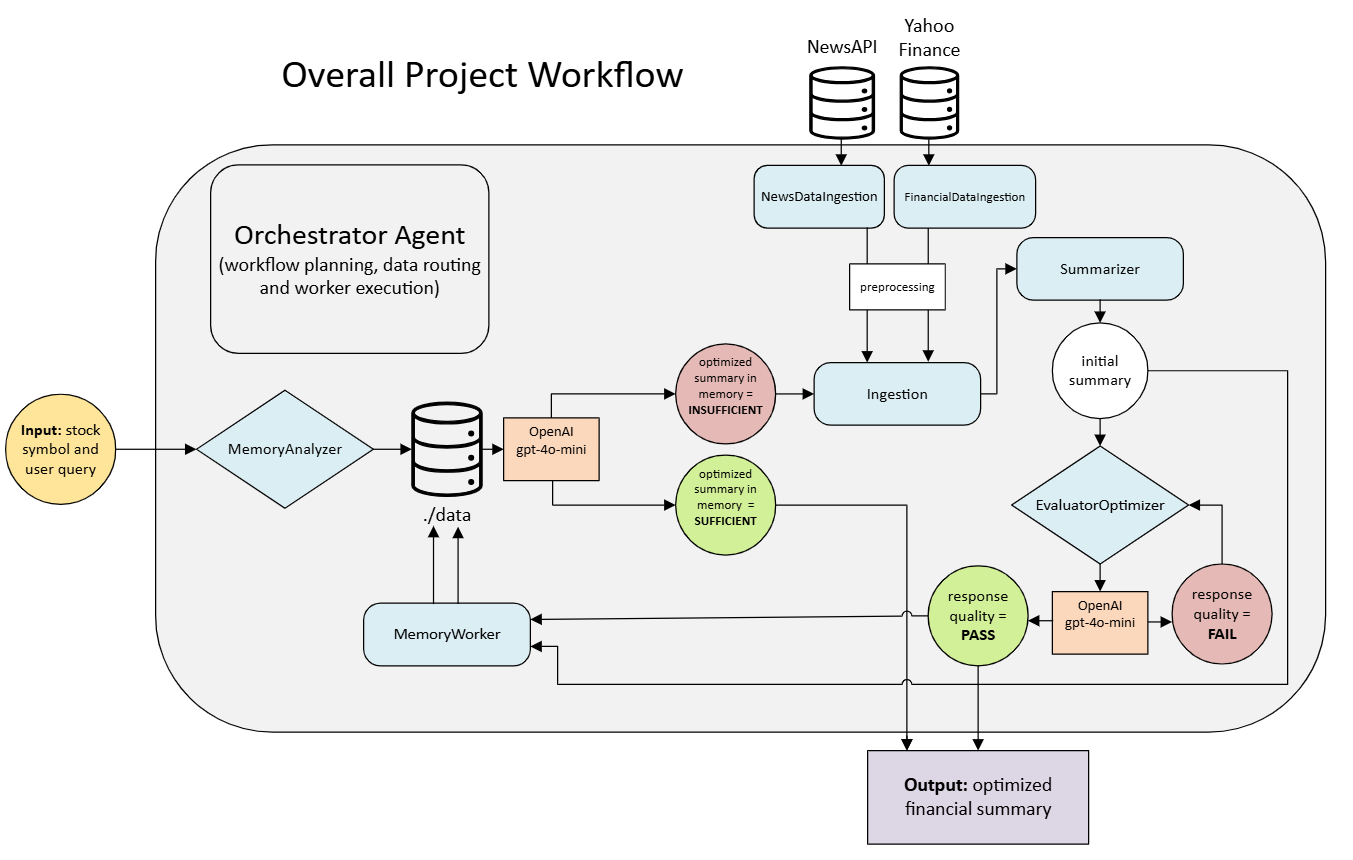

In [15]:
# Display image for overall project workflow
display(Image(filename="overall_project_workflow.png", width=1500))

# 1. MemoryAnalyzer

<b>Memory = Sufficient:</b>

assessment.is_sufficient = True if memory content alone can answer the query

is_data_fresh = True if memory is recent enough when freshness is required

<br><b>Memory = Insufficient:</b>

missing_info = Lists specific content gaps; presence implies insufficient

assessment.requires_fresh_data = True if the query needs fresh data

is_data_fresh = False = insufficient

age_hours / memory_timestamp,  if memory is too old or missing timestamp = insufficient

In [3]:
# ---------------------------
# worker/base_worker.py
# ---------------------------
# ==============================================================================
# BASE WORKER CLASS
# ==============================================================================
# All worker classes inherit from BaseWorker and implement the execute() method

class BaseWorker:
    def execute(self, *inputs):
        """Execute the worker's main function. To be overridden by subclasses."""
        raise NotImplementedError("This method should be overridden by subclasses.")

class SufficiencyAssessment(BaseModel):
    """Structured assessment of whether memory data is sufficient to answer a query"""

    is_sufficient: bool = Field(
        description="Whether the memory data contains enough information to fully answer the query"
    )
    requires_fresh_data: bool = Field(
        description="Whether this query requires the most current data (e.g., current prices, recent news) or can use older data (e.g., follow-up questions, general analysis)"
    )
    missing_information: list[str] = Field(
        description="List of specific information gaps that would be needed to fully answer the query",
        default_factory=list
    )

# ---------------------------
# src/memory_analyzer/memory_analyzer.py
# ---------------------------

class MemoryAnalyzer(BaseWorker):
    """
    Analyzes whether existing memory data is sufficient to answer a user query.
    Uses LangChain to perform intelligent assessment of data completeness.
    """

    def __init__(self):
        """Initialize the MemoryAnalyzer with OpenAI LLM"""
        super().__init__()
        self.llm = self._initialize_llm()
        self.structured_llm = self.llm.with_structured_output(SufficiencyAssessment)

    def _initialize_llm(self) -> ChatOpenAI:
        """Initialize OpenAI LLM with API key from environment"""
        api_key = os.getenv("OPENAI_API_KEY")

        if not api_key:
            raise ValueError(
                "OPENAI_API_KEY not found in environment variables. "
                "Please set it in your .env file."
            )

        return ChatOpenAI(
            model="gpt-4o-mini",
            temperature=0.1,  # Low temperature for consistent analysis
            api_key=api_key
        )

    def _extract_timestamp(self, memory_snapshot: str) -> datetime:
        """
        Extract timestamp from memory snapshot.
        Looks for patterns like "Timestamp: YYYY-MM-DD HH:MM:SS" or similar.

        Returns:
            datetime object if found, None otherwise
        """
        # Common timestamp patterns
        patterns = [
            r'Timestamp:\s*(\d{4}-\d{2}-\d{2}[T\s]\d{2}:\d{2}:\d{2})',
            r'Date:\s*(\d{4}-\d{2}-\d{2}[T\s]\d{2}:\d{2}:\d{2})',
            r'Created:\s*(\d{4}-\d{2}-\d{2}[T\s]\d{2}:\d{2}:\d{2})',
            r'Updated:\s*(\d{4}-\d{2}-\d{2}[T\s]\d{2}:\d{2}:\d{2})',
            r'(\d{4}-\d{2}-\d{2}[T\s]\d{2}:\d{2}:\d{2})',  # Just the timestamp
        ]

        for pattern in patterns:
            match = re.search(pattern, memory_snapshot, re.IGNORECASE)
            if match:
                timestamp_str = match.group(1)
                try:
                    # Handle both "T" separator and space separator
                    if 'T' not in timestamp_str:
                        timestamp_str = timestamp_str.replace(' ', 'T')
                    return datetime.fromisoformat(timestamp_str)
                except ValueError:
                    continue

        return None

    def execute(self, memory_snapshot: str, query: str) -> Dict[str, Any]:
        """
        Analyze if the memory snapshot contains sufficient data to answer the query,
        considering both content relevance and data freshness.

        Args:
            memory_snapshot: String containing the current memory data
            query: User's query/question

        Returns:
            Dictionary with:
                - is_sufficient: Boolean indicating if data is sufficient
                - requires_fresh_data: Boolean indicating if query requires fresh data
                - missing_information: List of gaps
        """
        if not memory_snapshot or not memory_snapshot.strip():
            return {
                "is_sufficient": False,
                "requires_fresh_data": True,  # Conservative assumption when no data exists
                "missing_information": ["All information - no memory data exists"]
            }

        # Extract timestamp from memory snapshot
        memory_timestamp = self._extract_timestamp(memory_snapshot)

        # Define freshness threshold:
        # Current datetime
        current_dt = datetime.now()
        # Freshness threshold in hours
        freshness_threshold_hours = 24
            
        is_data_fresh = True
        age_hours = 0

        if memory_timestamp:
            age_hours = (current_dt - memory_timestamp).total_seconds() / 3600
            is_data_fresh = age_hours <= freshness_threshold_hours
        else:
            # If no timestamp found, assume data might be stale
            is_data_fresh = False

        # Create analysis prompt
        data_age_info = f"Data age: {age_hours:.1f} hours old" if memory_timestamp else "Data age: unknown"
        prompt = f"""You are an expert financial analyst evaluating whether existing research data is sufficient to answer a user's query.

USER QUERY:
{query}

AVAILABLE MEMORY DATA:
{memory_snapshot}

DATA FRESHNESS: {data_age_info}

ANALYSIS TASK:
Determine if the available memory data contains enough information to fully and accurately answer the user's query.

Consider:
1. Does the data directly address the query topic?
2. Are there specific facts, metrics, or analysis needed to answer the query?
3. Does this query require the most current/fresh data (e.g., current prices, breaking news, real-time metrics) or can it use older data (e.g., follow-up questions, general analysis, historical context)?
4. Are there any gaps that would require additional research?

IMPORTANT: If you are uncertain whether the data is sufficient, err on the side of caution and mark it as insufficient.

Provide a structured assessment of data sufficiency."""

        try:
            # Get structured assessment from LLM
            assessment = self.structured_llm.invoke(prompt)

            # Consider both content sufficiency and data freshness
            content_sufficient = assessment.is_sufficient
            requires_fresh = assessment.requires_fresh_data

            # Final sufficiency decision: content must be sufficient AND data must be fresh if required
            final_sufficient = content_sufficient and (not requires_fresh or is_data_fresh)

            # Build missing information list
            missing_info = assessment.missing_information.copy()
            if requires_fresh and not is_data_fresh:
                age_msg = f"Data is too old ({age_hours:.1f} hours > {freshness_threshold_hours} hour threshold)"
                if age_msg not in missing_info:
                    missing_info.insert(0, age_msg)

            # Convert to dictionary for return
            result = {
                "is_sufficient": final_sufficient,
                "requires_fresh_data": requires_fresh,
                "missing_information": missing_info
            }

            return result

        except Exception as e:
            # Fallback to basic keyword matching if LLM fails
            print(f"LLM analysis failed: {e}")
            return {
                "is_sufficient": False, # automatically mark as insufficient so data can be refetched
                "requires_fresh_data": True,  # Conservative assumption when LLM fails
                "missing_information": ["LLM analysis unavailable"]
            }

# 2. Data Ingestion

## Overview
The Ingestion module is responsible for collecting financial and news data from multiple sources in parallel. It consists of three main components:

1. **FinancialDataIngestion**: Fetches stock data from Yahoo Finance (yfinance)
   - Historical OHLCV data (Open, High, Low, Close, Volume)
   - Company fundamentals (P/E ratio, market cap, beta, sector)
   - Calculated metrics (volatility, price changes, volume averages)

2. **NewsDataIngestion**: Fetches news articles from multiple sources
   - NewsAPI for general financial news
   - Yahoo Finance RSS feeds for stock-specific news
   - Preprocesses text to remove HTML and malicious content

3. **Ingestion (Coordinator)**: Orchestrates parallel data fetching
   - Executes financial and news ingestion concurrently using ThreadPoolExecutor
   - Handles partial failures gracefully
   - Combines results into a unified data bundle

## Data Flow
```
User Request → Ingestion.execute(symbol)
    ├─→ FinancialDataIngestion.execute(symbol, period) [Thread 1]
    │   └─→ Returns: financial metrics, historical data, company info
    └─→ NewsDataIngestion.execute(symbol, limit) [Thread 2]
        └─→ Returns: articles from NewsAPI + Yahoo RSS
                ↓
    Combined Result: {financial_data, news_data, errors, status}
```

In [4]:
# ---------------------------
# (step 1)
# ingestion/financial_data.py (file 1 of 3)
# (Yahoo Finance data fetching, metrics calculation, and error handling, data structuring.)
# ---------------------------

# ==============================================================================
# FINANCIAL DATA INGESTION WORKER
# ==============================================================================
# Purpose: Fetch stock data from Yahoo Finance API (yfinance)
# Responsibilities:
#   - Retrieve historical OHLCV data (Open, High, Low, Close, Volume)
#   - Fetch company fundamentals (P/E ratio, market cap, sector, industry)
#   - Calculate derived metrics (volatility, price changes, volume averages)
#   - Handle API errors and return structured data
# ==============================================================================

"""
NLP-5: Financial Data Ingestion
Fetch stock data from Yahoo Finance API (yfinance)
"""

class FinancialDataIngestion(BaseWorker):
    """
    Fetches financial data from Yahoo Finance.

    Responsibilities:
    - Fetch historical OHLCV (Open, High, Low, Close, Volume) data
    - Fetch company information and fundamentals
    - Calculate basic metrics from raw data
    - Handle API errors gracefully
    - Return structured financial data
    """

    def execute(self, *inputs) -> Dict[str, Any]:
        """
        Fetch financial data for a given stock symbol.

        Args:
            inputs[0] (str): Stock ticker symbol (e.g., "AAPL")
            inputs[1] (str, optional): Time period (default: "1mo")
                Valid periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max

        Returns:
            dict: Financial data bundle containing:
                - symbol: Stock ticker
                - price metrics: Current price, changes, highs/lows
                - volume metrics: Current and average volume
                - volatility: Calculated volatility
                - fundamentals: P/E ratio, market cap, beta, etc.
                - company info: Sector, industry, summary
                - historical_data: Recent OHLCV records
                - status: Success or error status
        """
        try:
            symbol = inputs[0]
            period = inputs[1] if len(inputs) > 1 else "1mo"

            stock = yf.Ticker(symbol)

            # Fetch historical OHLCV data from Yahoo Finance
            hist = stock.history(period=period)

            if hist.empty:
                return {
                    "source": "yahoo_finance",
                    "symbol": symbol,
                    "data": None,
                    "status": "error",
                    "error": f"No data found for symbol {symbol}",
                    "timestamp": datetime.now().isoformat()
                }

            info = stock.info

            # Extract price metrics from historical data
            current_price = hist['Close'].iloc[-1]
            prev_close = info.get('previousClose', hist['Close'].iloc[-2] if len(hist) > 1 else current_price)
            price_change = current_price - prev_close
            price_change_pct = (price_change / prev_close) * 100 if prev_close != 0 else 0

            # Calculate annualized volatility using standard deviation of returns
            # Formula: std(daily_returns) * sqrt(trading_days_per_year)
            returns = hist['Close'].pct_change().dropna()
            volatility = returns.tail(30).std() * (252 ** 0.5) if len(returns) > 0 else 0

            # Calculate volume statistics
            avg_volume = hist['Volume'].tail(30).mean()
            current_volume = hist['Volume'].iloc[-1]

            # Raw data result from yf
            result = {
                "source": "yahoo_finance",
                "symbol": symbol,
                "data": {
                    "current_price": float(current_price),
                    "price_change": float(price_change),
                    "price_change_pct": float(price_change_pct),
                    "volume": int(current_volume),
                    "avg_volume_30d": float(avg_volume),
                    "volatility_30d": float(volatility),
                    "market_cap": info.get("marketCap"),
                    "pe_ratio": info.get("forwardPE"),
                    "dividend_yield": info.get("dividendYield"),
                    "52_week_high": info.get("fiftyTwoWeekHigh"),
                    "52_week_low": info.get("fiftyTwoWeekLow"),
                    "beta": info.get("beta"),
                    "sector": info.get("sector"),
                    "industry": info.get("industry"),
                    "company_summary": info.get("longBusinessSummary", "")[:500],
                    "historical_data": hist.tail(30).to_dict('records')
                },
                "status": "success",
                "error": None,
                "timestamp": datetime.now().isoformat()
            }

            return result

        except Exception as e:
            return {
                "source": "yahoo_finance",
                "symbol": inputs[0] if len(inputs) > 0 else "UNKNOWN",
                "data": None,
                "status": "error",
                "error": str(e),
                "timestamp": datetime.now().isoformat()
            }
# ---------------------------
# (step 1)
# ingestion/news_data.py (file 2 of 3)
# ---------------------------

# ==============================================================================
# NEWS DATA INGESTION WORKER
# ==============================================================================
# Purpose: Fetch news articles from multiple sources
# Responsibilities:
#   - Query NewsAPI for general financial news
#   - Fetch Yahoo Finance RSS feeds for stock-specific news
#   - Preprocess text to remove HTML tags and malicious content
#   - Return structured list of articles with metadata
# ==============================================================================

"""
NLP-6: News Data Ingestion
Fetch news articles from NewsAPI and Yahoo Finance RSS
"""

class NewsDataIngestion(BaseWorker):
    """
    Fetches news data from multiple sources.

    Responsibilities:
    - Fetch news articles from NewsAPI
    - Fetch news from Yahoo Finance RSS feeds
    - Handle API errors and rate limits gracefully
    - Return structured list of articles
    """

    DEFAULT_LIMIT = 10

    def __init__(self):
        super().__init__()

    def execute(self, *inputs) -> Dict[str, Any]:
        """
        Fetch news articles for a given stock symbol.

        Args:
            inputs[0] (str): Stock ticker symbol (e.g., "AAPL")
            inputs[1] (int, optional): Number of articles to fetch (default: 10)

        Returns:
            dict: News data bundle containing:
                - articles: List of articles from all sources
                - sources_queried: Which sources were successfully queried
                - total_count: Total number of articles fetched
                - status: Success or error status
        """
        try:
            symbol = inputs[0]
            limit = inputs[1] if len(inputs) > 1 else self.DEFAULT_LIMIT

            articles = []
            sources_queried = []
            errors = []

            # Fetch from Yahoo Finance RSS feed
            # Allocate half of article limit to this source
            try:
                yahoo_articles = self._fetch_from_yahoo_rss(symbol, limit // 2)
                articles.extend(yahoo_articles)
                sources_queried.append("yahoo_rss")
            except Exception as e:
                errors.append({"source": "yahoo_rss", "error": str(e)})

            # Fetch from NewsAPI
            # Allocate remaining half of article limit to this source
            if NEWS_API_KEY:
                try:
                    newsapi_articles = self._fetch_from_newsapi(symbol, limit // 2)
                    articles.extend(newsapi_articles)
                    sources_queried.append("newsapi")
                except Exception as e:
                    errors.append({"source": "newsapi", "error": str(e)})
            else:
                errors.append({"source": "newsapi", "error": "NEWS_API_KEY not found in environment"})

            return {
                "source": "news_aggregated",
                "symbol": symbol,
                "data": {
                    "articles": articles,
                    "sources_queried": sources_queried,
                    "total_count": len(articles)
                },
                "status": "success" if len(articles) > 0 else "partial_success",
                "error": errors if len(errors) > 0 else None,
                "timestamp": datetime.now().isoformat()
            }

        except Exception as e:
            return {
                "source": "news_aggregated",
                "symbol": inputs[0] if len(inputs) > 0 else "UNKNOWN",
                "data": {
                    "articles": [],
                    "sources_queried": [],
                    "total_count": 0
                },
                "status": "error",
                "error": str(e),
                "timestamp": datetime.now().isoformat()
            }

    def _preprocess_text(self, text: str) -> str:
        # Text preprocessing: Remove potentially malicious content and HTML
        # Step 1: Remove script tags and their content
        text = re.sub(r'(?is)<script.*?>.*?</script>', ' ', text)

        # Remove any remaining HTML tags
        text = re.sub(r'<[^>]+>', ' ', text)

        # Remove javascript: URIs and inline event handlers like onload=, onclick= etc.
        text = re.sub(r'(?i)javascript\s*:', '', text)
        text = re.sub(r'(?i)on\w+\s*=\s*["\'].*?["\']', ' ', text)

        # Remove control characters
        text = re.sub(r'[\x00-\x1f\x7f]', ' ', text)

        # Unescape HTML entities then escape to ensure safe plain text
        text = html.unescape(text)
        text = html.escape(text)

        # Collapse multiple whitespace to single space and trim
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def _fetch_from_newsapi(self, symbol: str, limit: int) -> List[Dict[str, Any]]:
        """
        Fetch articles from NewsAPI.

        Args:
            symbol: Stock ticker symbol
            limit: Maximum number of articles

        Returns:
            List of article dictionaries
        """
        url = "https://newsapi.org/v2/everything"
        params = {
            "q": f"{symbol} stock",
            "language": "en",
            "sortBy": "publishedAt",
            "pageSize": limit,
            "apiKey": NEWS_API_KEY
        }

        response = requests.get(url, params=params, timeout=10)

        if response.status_code == 200:
            data = response.json()
            articles = []
            for article in data.get("articles", []):
                processed_summary = self._preprocess_text(article.get("description", ""))
                articles.append({
                    "title": article.get("title", ""),
                    "link": article.get("url", ""),
                    "published": article.get("publishedAt", ""),
                    "summary": processed_summary,
                    "source": article.get("source", {}).get("name", "NewsAPI")
                })
            return articles
        else:
            raise Exception(f"NewsAPI request failed with status {response.status_code}")

    def _fetch_from_yahoo_rss(self, symbol: str, limit: int) -> List[Dict[str, Any]]:
        """
        Fetch articles from Yahoo Finance RSS feed.

        Args:
            symbol: Stock ticker symbol
            limit: Maximum number of articles

        Returns:
            List of article dictionaries
        """
        yahoo_rss = f"https://feeds.finance.yahoo.com/rss/2.0/headline?s={symbol}&region=US&lang=en-US"
        feed = feedparser.parse(yahoo_rss)

        articles = []
        for entry in feed.entries[:limit]:
            processed_summary = self._preprocess_text(entry.get("summary", ""))
            articles.append({
                "title": entry.get("title", ""),
                "link": entry.get("link", ""),
                "published": entry.get("published", ""),
                "summary": processed_summary,
                "source": "Yahoo Finance"
            })

        return articles

# ---------------------------
# (step 1)
# ingestion/ingestion.py (file 3 of 3)
# ---------------------------
# ==============================================================================
# INGESTION COORDINATOR
# ==============================================================================
# Purpose: Orchestrate parallel data fetching from multiple sources
# Pattern: Uses ThreadPoolExecutor for concurrent API calls
# Responsibilities:
#   - Execute financial and news ingestion in parallel
#   - Combine results into unified data bundle
#   - Handle partial failures gracefully
#   - Track errors from each source
# ==============================================================================

"""
Main Ingestion Coordinator
Orchestrates parallel data fetching from financial and news sources (simplified)
"""

class Ingestion(BaseWorker):
    """
    Main Ingestion Coordinator that fetches data from financial and news sources in parallel.

    Responsibilities:
    - Coordinate parallel data fetching from financial and news sources
    - Combine results into single bundle
    - Handle partial failures gracefully
    - Track errors from each source
    - Return complete data bundle
    """

    def __init__(self):
        """Initialize data ingestors."""
        self.financial_ingestor = FinancialDataIngestion()
        self.news_ingestor = NewsDataIngestion()

    def execute(self, *inputs) -> Dict[str, Any]:
        """
        Execute parallel data ingestion from all sources.

        Args:
            inputs[0] (str): Stock ticker symbol (e.g., "AAPL")
            inputs[1] (str, optional): Time period for historical data (default: "1mo")
            inputs[2] (int, optional): Number of news articles (default: 10)

        Returns:
            dict: Complete data bundle with financial and news data
        """
        try:
            # Extract parameters
            symbol = inputs[0] if len(inputs) > 0 else "AAPL"
            period = inputs[1] if len(inputs) > 1 else "1mo"
            news_limit = inputs[2] if len(inputs) > 2 else 10

            # Execute both financial and news ingestion concurrently
            results = self._execute_parallel(symbol, period, news_limit)

            # Combine results
            bundle = self._combine_results(symbol, results)

            return bundle

        except Exception as e:
            return {
                "symbol": inputs[0] if len(inputs) > 0 else "UNKNOWN",
                "timestamp": datetime.now().isoformat(),
                "financial_data": None,
                "news_data": None,
                "errors": [{"source": "ingestion_coordinator", "error": str(e)}],
                "status": "error"
            }

    def _execute_parallel(self, symbol: str, period: str, news_limit: int) -> Dict[str, Any]:
        """
        Execute all ingestion tasks in parallel.

        Args:
            symbol: Stock ticker symbol
            period: Time period for historical data
            news_limit: Number of news articles

        Returns:
            Dictionary with results from all sources
        """
        results = {
            "financial": None,
            "news": None
        }

        with ThreadPoolExecutor(max_workers=2) as executor:
            # Submit both ingestion tasks to thread pool for parallel execution
            future_to_source = {
                executor.submit(self.financial_ingestor.execute, symbol, period): "financial",
                executor.submit(self.news_ingestor.execute, symbol, news_limit): "news"
            }

            # Collect results as they complete
            for future in as_completed(future_to_source):
                source = future_to_source[future]
                try:
                    result = future.result()
                    results[source] = result
                except Exception as e:
                    results[source] = {
                        "source": source,
                        "data": None,
                        "status": "error",
                        "error": str(e),
                        "timestamp": datetime.now().isoformat()
                    }

        return results

    def _combine_results(self, symbol: str, results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Combine results from all ingestors into single bundle.

        Args:
            symbol: Stock ticker symbol
            results: Dictionary with results from each ingestor

        Returns:
            Combined data bundle
        """
        errors = []

        # Extract financial data
        financial_result = results.get("financial", {})
        financial_data = financial_result.get("data") if financial_result.get("status") == "success" else None
        if financial_result.get("error"):
            errors.append({"source": "financial", "error": financial_result.get("error")})

        # Extract news data
        news_result = results.get("news", {})
        news_data = news_result.get("data") if news_result.get("status") in ["success", "partial_success"] else None
        if news_result.get("error"):
            errors.append({"source": "news", "error": news_result.get("error")})

        # Determine overall status
        status = self._determine_status(results)

        return {
            "symbol": symbol,
            "timestamp": datetime.now().isoformat(),
            "financial_data": financial_data,
            "news_data": news_data,
            "errors": errors,
            "status": status
        }

    def _determine_status(self, results: Dict[str, Any]) -> str:
        """
        Determine overall ingestion status based on results.

        Args:
            results: Dictionary with results from each ingestor

        Returns:
            Status string: "success", "partial_success", or "error"
        """
        success_count = 0
        total_count = len(results)

        for source, result in results.items():
            if result and result.get("status") in ["success", "partial_success"]:
                success_count += 1

        if success_count == total_count:
            return "success"
        elif success_count > 0:
            return "partial_success"
        else:
            return "error"

# 3. Summarizer
- Formats Ingestion data into structured insight with routed notes
- Summary is stored as summary_result["summary"]

In [5]:
# ---------------------------
# (step 2)
# src/summarizer/summarizer.py
# ---------------------------

# --- Simple keyword routing for headlines ---
ROUTES = {
    "earnings": ["eps", "guidance", "revenue", "call", "forecast", "beat", "miss", "margin"],
    "macro":    ["fed", "rate", "cpi", "inflation", "jobs", "gdp", "unemployment", "yields", "oil"],
    "company":  ["product", "launch", "recall", "supply", "lawsuit", "merger", "partnership", "contract"],
}

def _route(text: str) -> str:
    t = (text or "").lower()
    for route, keys in ROUTES.items():
        if any(k in t for k in keys):
            return route
    return "company"

PROMPT_TEMPLATE = """You are a pragmatic equity analyst.
Goal: {goal}
Symbol: {symbol}

Context (recent daily stats + sampled headlines):
{context}

Write 5–8 concise bullets on likely near-term price *drivers* and 2 bullets on *key risks*.
Avoid hype; be specific. Include dates or sources inline when present.
"""

class SummarizerWorker(BaseWorker):
    def __init__(self, name: str = "summarizer", role: str = "news_summary", model: str | None = None):
        """
        Defensive init:
        - Try BaseWorker's init; if different signature, just set attributes.
        """
        try:
            super().__init__(name=name, role=role, model=model)  # type: ignore[misc]
        except TypeError:
            try:
                super().__init__()  # type: ignore[misc]
            except Exception:
                pass
            setattr(self, "name", name)
            setattr(self, "role", role)
            setattr(self, "model", model)

    def execute(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        """
        Entry point for the summarizer agent.
        """
        symbol: str = inputs["symbol"]
        news_daily = inputs.get("news_daily")
        raw_news   = inputs.get("raw_news")
        window     = int(inputs.get("window", 7))
        goal       = inputs.get("analysis_goal", f"Next-week price drivers for {symbol}")

        context = self._format_context(news_daily, raw_news, window)
        routed  = self._route_headlines(raw_news)
        prompt  = PROMPT_TEMPLATE.format(goal=goal, symbol=symbol, context=context)

        # Stub—replace with your LLM call
        summary_text = (
            "(Stubbed summary — replace with your LLM call)\n"
            + prompt
            + "\n- Headlines cluster around a few catalysts; monitor official updates.\n"
              "- Tone is slightly positive; momentum sensitive to macro prints.\n"
              "- Risks: guidance/margin pressure; policy surprises."
        )

        memory_writes = [
            f"[{symbol}] {window}d summary",
            f"[{symbol}] Routes: " + ", ".join([k for k, v in routed.items() if v])
        ]

        return {
            "symbol": symbol,
            "summary": summary_text,
            "routed_notes": routed,
            "artifacts": {"prompt": prompt},
            "memory_writes": memory_writes,
        }

    # ----------------- Helpers -----------------
    def _format_context(
        self,
        news_daily,
        raw_news,  # Union[List[dict], "pd.DataFrame", None] at runtime
        window: int
    ) -> str:
        parts: List[str] = []

        # Daily aggregates
        if news_daily is not None and hasattr(news_daily, "tail") and len(news_daily) > 0:
            tail = news_daily.tail(window)
            parts.append("Daily sentiment (most recent first):")
            for idx, row in tail.iloc[::-1].iterrows():
                parts.append(
                    f"- {idx}: count={int(row.get('news_count', 0))}, "
                    f"sent_mean={row.get('sent_mean', 0):+.3f}, decay={row.get('sent_decay', 0):+.3f}"
                )

        # Recent headlines
        if raw_news is not None:
            try:
                import pandas as pd
                df = raw_news if isinstance(raw_news, pd.DataFrame) else pd.DataFrame(raw_news)
                cols = [c for c in ["date", "source", "title"] if c in df.columns]
                if cols:
                    parts.append("\nRecent headlines:")
                    for _, r in df.tail(min(12, len(df))).iloc[::-1].iterrows():
                        parts.append("- " + " | ".join(str(r.get(c, "")) for c in cols))
            except Exception:
                pass

        return "\n".join(parts) if parts else "(No news context available)"

    def _route_headlines(self, raw_news) -> dict:
        routed = {"earnings": [], "macro": [], "company": []}
        if raw_news is None:
            return routed
        try:
            import pandas as pd
            df = raw_news if isinstance(raw_news, pd.DataFrame) else pd.DataFrame(raw_news)
            for _, r in df.tail(50).iterrows():
                ttl = str(r.get("title", "")) or ""
                routed[_route(ttl)].append(ttl)
        except Exception:
            pass
        # Trim to a few examples per bucket
        return {k: v[:5] for k, v in routed.items()}


# 4. Memory Management

## Overview
The Memory module provides persistent storage for agent learnings across multiple runs. It enables the system to:
- Store analysis results and insights
- Retrieve historical context for subsequent queries
- Build knowledge over time for improved decision-making

## Key Features

### Storage
- **File-based persistence**: Stores memories in `data/agent_memory.json`
- **Tagged entries**: Each memory includes tags (e.g., symbol, category) for efficient retrieval
- **Timestamped records**: All entries include ISO-formatted timestamps for freshness tracking

### Operations
1. **add**: Store new memory entries with text and optional tags
2. **search**: Find memories by keyword matching in text or tags
3. **get_recent**: Retrieve the N most recent memories
4. **retrieve_by_symbol**: Get all memories related to a specific stock symbol

## Memory Structure
```python
{
  "timestamp": "2025-10-19T10:30:00",
  "text": "[AAPL] Investment recommendation: Hold",
  "tags": ["AAPL", "summary", "optimized"]
}
```

## Usage in Workflow
- **After Summarization**: Store summary notes and routing information
- **After Optimization**: Store final optimized summaries
- **Before New Analysis**: Retrieve previous context to avoid redundant API calls

In [6]:
# ---------------------------
# (step 3)
# src/memory/memory.py
# ---------------------------

# ==============================================================================
# MEMORY MANAGEMENT MODULE
# ==============================================================================
# Purpose: Provide persistent storage for agent learnings across runs
# Storage: JSON file-based persistence in ./data/agent_memory.json
# Structure: List of dictionaries with timestamp, text, and tags
# ==============================================================================

# Global in-memory store synchronized with JSON file
_memory_store: List[Dict[str, Any]] = []
MEMORY_FILE = "./data/agent_memory.json"

def _load_memory():
    """
    Load memories from JSON file into the in-memory list.
    Called automatically when module is imported.
    Handles missing files and JSON decode errors gracefully.
    """
    global _memory_store
    if not os.path.exists(MEMORY_FILE):
        _memory_store = []
        return
    try:
        with open(MEMORY_FILE, "r", encoding="utf-8") as f:
            _memory_store = json.load(f)
    except (json.JSONDecodeError, FileNotFoundError):
        _memory_store = []

def _save_memory():
    """
    Save the in-memory list to JSON file for persistence.
    Creates directory if it doesn't exist.
    Called after each add operation.
    """
    os.makedirs(os.path.dirname(MEMORY_FILE), exist_ok=True)
    with open(MEMORY_FILE, "w", encoding="utf-8") as f:
        json.dump(_memory_store, f, indent=2)

# Load memory when module is imported
_load_memory()

class MemoryWorker(BaseWorker):
    """
    Worker for managing agent memories with persistent storage.

    A BaseWorker implementation for managing agent memories. It stores short text
    memories with optional tags in a JSON file so the agent can learn across runs.
    """
    def execute(self, *inputs) -> Any:
        """
        Manages agent memories. The first input is the operation ('add', 'search', 'get_recent', 'retrieve_by_symbol').

        Usage:
            - execute('add', 'some memory text', ['tag1', 'tag2'])
            - execute('search', 'query text')
            - execute('get_recent', 5)
            - execute('retrieve_by_symbol', 'AAPL')
        """
        if not inputs:
            raise ValueError("MemoryWorker requires at least one input for the operation.")

        operation = inputs[0]

        # ---------------------------------------------------------------------
        # ADD OPERATION: Store new memory entry
        # ---------------------------------------------------------------------
        if operation == 'add':
            if len(inputs) < 2:
                raise ValueError("The 'add' operation requires text for the memory.")
            text = inputs[1]
            tags = inputs[2] if len(inputs) > 2 else []
            # Create memory entry with ISO-formatted UTC timestamp
            entry = {
                "timestamp": datetime.now(timezone.utc).isoformat(),
                "text": text,
                "tags": tags,
            }
            _memory_store.append(entry)
            _save_memory()
            return entry

        # ---------------------------------------------------------------------
        # SEARCH OPERATION: Find memories by keyword matching
        # ---------------------------------------------------------------------
        elif operation == 'search':
            if len(inputs) < 2:
                raise ValueError("The 'search' operation requires a query string.")
            query = inputs[1].lower()
            top_k = inputs[2] if len(inputs) > 2 else 5

            # Search in reverse chronological order (most recent first)
            # Match query against text content or tags (case-insensitive)
            matches = [
                m for m in reversed(_memory_store)
                if query in m['text'].lower() or any(query in t.lower() for t in m.get('tags', []))
            ]
            return matches[:top_k]

        # ---------------------------------------------------------------------
        # GET_RECENT OPERATION: Retrieve N most recent memories
        # ---------------------------------------------------------------------
        elif operation == 'get_recent':
            n = inputs[1] if len(inputs) > 1 else 5
            return list(reversed(_memory_store))[:n]

        # ---------------------------------------------------------------------
        # RETRIEVE_BY_SYMBOL OPERATION: Get all memories for a stock symbol
        # ---------------------------------------------------------------------
        elif operation == 'retrieve_by_symbol':
            if len(inputs) < 2:
                raise ValueError("The 'retrieve_by_symbol' operation requires a symbol string.")
            symbol = inputs[1].upper()  # Normalize to uppercase for consistency

            # Filter records by symbol (case-insensitive)
            # Matches if symbol appears in tags or text content
            matches = [
                m for m in _memory_store
                if symbol in [tag.upper() for tag in m.get('tags', [])] or symbol in m.get('text', '').upper()
            ]
            return matches

        else:
            raise ValueError(f"Unknown operation: {operation}. Available operations: 'add', 'search', 'get_recent', 'retrieve_by_symbol'.")

# 5. EvaluatorOptimizer

In [7]:
# ---------------------------
# (step 4)
# evaluator_optimizer/init.py
# ---------------------------

"""
Evaluator-Optimizer Module

Implements the Evaluator-Optimizer workflow pattern for iterative refinement
of investment research summaries.
"""

__all__ = ["EvaluatorOptimizer", "Feedback", "State"]

# ---------------------------
# (step 4)
# evaluator_optimizer/evaluator_optimizer.py
# ---------------------------

"""
Evaluator-Optimizer Module

Implements the Evaluator-Optimizer workflow pattern where:
1. Generator creates an investment research summary
2. Evaluator assesses quality and provides feedback
3. Loop continues until quality passes or max iterations reached
4. Final summary is stored in memory

Based on LangGraph pattern: https://langchain-ai.github.io/langgraph/tutorials/workflows/#evaluator-optimizer
"""

# --- State Definition ---
class State(TypedDict):
    """Graph state for the Evaluator-Optimizer workflow"""
    symbol: str  # Stock symbol being analyzed
    instructions: str  # User's request/query about the stock
    context: Dict[str, Any]  # Financial data context (news, prices, etc.)
    summary: str  # Current investment research summary
    feedback: str  # Feedback from evaluator
    grade: str  # Quality grade: "pass" or "fail"
    quality_score: float  # Numeric quality score (0-10)
    issues: List[str]  # List of identified issues
    iteration: int  # Current iteration number
    max_iterations: int  # Maximum allowed iterations
    history: List[Dict[str, Any]]  # History of iterations for tracking

# --- Structured Output Schema for Evaluation ---
class Feedback(BaseModel):
    """Structured evaluation feedback from the Evaluator"""

    grade: Literal["pass", "fail"] = Field(
        description="Overall quality assessment: 'pass' if summary meets quality criteria, 'fail' otherwise"
    )
    quality_score: float = Field(
        description="Numeric quality score from 0-10, where 10 is excellent",
        ge=0.0,
        le=10.0
    )
    feedback: str = Field(
        description="Detailed, actionable feedback for improving the summary if grade is 'fail'"
    )
    issues: List[str] = Field(
        description="List of specific issues identified in the summary",
        default_factory=list
    )

# --- Evaluator-Optimizer Class ---
class EvaluatorOptimizer(BaseWorker):
    """
    Implements the Evaluator-Optimizer workflow pattern for investment research summaries.

    The workflow:
    1. Generator creates an initial summary from context data
    2. Evaluator assesses quality against defined criteria
    3. If quality fails, provides feedback and loops back to Generator
    4. Continues until quality passes or max iterations reached
    5. Returns final optimized summary
    """

    # Quality criteria for investment research summaries
    QUALITY_CRITERIA = """
    A high-quality investment research summary should:
    1. COMPLETENESS: Cover key financial metrics, sentiment analysis, and risk factors
    2. CLARITY: Be well-structured, concise, and easy to understand
    3. ACTIONABILITY: Include a clear investment recommendation (buy/sell/hold) with rationale
    4. EVIDENCE-BASED: Back claims with specific data from news and financial metrics
    5. COHERENCE: Have logical flow without contradictions
    6. RISK AWARENESS: Acknowledge both opportunities and risks
    """

    def __init__(self, llm: Optional[ChatOpenAI] = None, max_iterations: int = 3):
        """
        Initialize the Evaluator-Optimizer.

        Args:
            llm: Language model instance (if None, initializes OpenAI LLM from environment)
            max_iterations: Maximum refinement iterations before stopping
        """
        # Initialize LLM
        if llm is not None:
            self.llm = llm
        else:
            self.llm = self._initialize_openai_llm()

        self.max_iterations = max_iterations

        # Create structured output LLM for evaluation
        self.evaluator_llm = self.llm.with_structured_output(Feedback)

        # Build the workflow graph
        self.workflow = self._build_workflow()

    def _initialize_openai_llm(self) -> ChatOpenAI:
        """Initialize OpenAI LLM with API key from environment"""
        api_key = os.getenv("OPENAI_API_KEY")
        llm = ChatOpenAI(
            model="gpt-4o-mini",  # Using gpt-4o-mini for cost efficiency
            temperature=0.7,
            api_key=api_key
        )
        return llm

    def _build_workflow(self) -> StateGraph:
        """Builds the LangGraph workflow for Evaluator-Optimizer pattern"""

        # Create the graph
        builder = StateGraph(State)

        # Add nodes
        builder.add_node("generator", self._generator_node)
        builder.add_node("evaluator", self._evaluator_node)

        # Add edges
        builder.add_edge(START, "generator")
        builder.add_edge("generator", "evaluator")

        # Conditional edge: loop back to generator or end
        builder.add_conditional_edges(
            "evaluator",
            self._should_continue,
            {
                "continue": "generator",  # Loop back with feedback
                "end": END  # Quality passed or max iterations reached
            }
        )

        # Compile the workflow
        return builder.compile()

    def _generator_node(self, state: State) -> Dict[str, Any]:
        """
        Generator Node: Creates or refines the investment research summary.

        On first iteration: creates initial summary from context
        On subsequent iterations: refines summary based on evaluator feedback
        """
        symbol = state["symbol"]
        context = state["context"]
        instructions = state.get("instructions", "")
        feedback = state.get("feedback", "")
        iteration = state.get("iteration", 0)

        # Format the context data
        formatted_context = self._format_context(context)

        # Build the prompt
        if iteration == 0:
            # Initial summary generation
            prompt = f"""You are an expert financial analyst. Create a comprehensive investment research summary for {symbol}.

USER REQUEST:
{instructions}

AVAILABLE DATA:
{formatted_context}

QUALITY REQUIREMENTS:
{self.QUALITY_CRITERIA}

INSTRUCTIONS:
1. Directly address the user's request/questions in your analysis
2. Use the provided financial data, news, and market context to support your analysis
3. If the user asked specific questions, answer them explicitly
4. If data is missing or unavailable, acknowledge it and work with what's available
5. Provide a clear investment recommendation (buy/sell/hold) with detailed rationale
6. Structure your response professionally with clear sections
7. Back all claims with specific data points from the context

Generate a well-structured investment research summary that meets all quality criteria and addresses the user's request."""
        else:
            # Refinement based on feedback
            current_summary = state["summary"]
            prompt = f"""You are refining an investment research summary for {symbol}.

USER REQUEST:
{instructions}

CURRENT SUMMARY:
{current_summary}

EVALUATOR FEEDBACK:
{feedback}

ISSUES IDENTIFIED:
{', '.join(state.get('issues', []))}

AVAILABLE DATA:
{formatted_context}

QUALITY REQUIREMENTS:
{self.QUALITY_CRITERIA}

INSTRUCTIONS:
1. Address all issues identified by the evaluator
2. Ensure the user's original request is still fully addressed
3. Improve clarity, completeness, and actionability
4. Add missing data points or analysis where needed
5. Maintain professional structure and tone

Generate an improved version that addresses all feedback and meets quality standards."""

        # Generate summary
        response = self.llm.invoke(prompt)
        new_summary = response.content

        # Update iteration count
        new_iteration = iteration + 1

        print(f"\n{'='*60}")
        print(f"GENERATOR - Iteration {new_iteration}")
        print(f"{'='*60}")
        print(f"User Request: {instructions[:80]}...")
        print(f"Summary generated ({len(new_summary)} characters)")
        if iteration > 0:
            print(f"Addressing feedback: {feedback[:100]}...")

        return {
            "summary": new_summary,
            "iteration": new_iteration
        }

    def _evaluator_node(self, state: State) -> Dict[str, Any]:
        """
        Evaluator Node: Assesses the quality of the summary and provides feedback.

        Uses structured output to return:
        - grade: "pass" or "fail"
        - quality_score: 0-10
        - feedback: actionable improvement suggestions
        - issues: specific problems identified
        """
        summary = state["summary"]
        symbol = state["symbol"]
        instructions = state.get("instructions", "")
        iteration = state["iteration"]

        # Evaluation prompt
        prompt = f"""You are a senior financial analyst evaluating an investment research summary for {symbol}.

USER'S ORIGINAL REQUEST:
{instructions}

SUMMARY TO EVALUATE:
{summary}

EVALUATION CRITERIA:
{self.QUALITY_CRITERIA}

ASSESSMENT REQUIREMENTS:
1. Does the summary directly address the user's request/questions?
2. Is the analysis backed by specific data points?
3. Are all quality criteria met (completeness, clarity, actionability, evidence-based, coherence, risk awareness)?
4. Is the investment recommendation clear and well-justified?
5. Are there any contradictions or unsupported claims?
6. Is the structure professional and easy to follow?

Provide:
- grade: "pass" if the summary meets professional standards and addresses the user's request, "fail" if significant improvements needed
- quality_score: 0-10 (be generous with 7+ for good work, reserve 9+ for exceptional analysis)
- feedback: Specific, actionable suggestions for improvement (if grade is "fail")
- issues: List specific problems (missing data, unclear reasoning, unanswered questions, etc.)

Be fair but thorough. A passing grade means the summary is publication-ready and fully addresses the user's needs."""

        # Get structured evaluation
        evaluation = self.evaluator_llm.invoke(prompt)

        # Track iteration history
        history = state.get("history", [])
        history.append({
            "iteration": iteration,
            "summary_length": len(summary),
            "grade": evaluation.grade,
            "quality_score": evaluation.quality_score,
            "issues_count": len(evaluation.issues)
        })

        print(f"\n{'='*60}")
        print(f"EVALUATOR - Iteration {iteration}")
        print(f"{'='*60}")
        print(f"Grade: {evaluation.grade.upper()}")
        print(f"Quality Score: {evaluation.quality_score}/10")
        print(f"Issues Found: {len(evaluation.issues)}")
        if evaluation.issues:
            for i, issue in enumerate(evaluation.issues, 1):
                print(f"  {i}. {issue}")
        print(f"Feedback: {evaluation.feedback[:150]}...")

        return {
            "grade": evaluation.grade,
            "quality_score": evaluation.quality_score,
            "feedback": evaluation.feedback,
            "issues": evaluation.issues,
            "history": history
        }

    def _should_continue(self, state: State) -> Literal["continue", "end"]:
        """
        Conditional routing: decide whether to continue refinement or end.

        Continue if:
        - Grade is "fail" AND
        - Haven't reached max iterations

        End if:
        - Grade is "pass" OR
        - Max iterations reached
        """
        grade = state["grade"]
        iteration = state["iteration"]
        max_iterations = state["max_iterations"]

        if grade == "pass":
            print(f"\nQuality PASSED - Ending optimization")
            return "end"
        elif iteration >= max_iterations:
            print(f"\nMax iterations ({max_iterations}) reached - Ending optimization")
            return "end"
        else:
            print(f"\nQuality FAILED - Continuing to iteration {iteration + 1}")
            return "continue"

    def _format_context(self, context: Dict[str, Any]) -> str:
        """Formats context data into a readable string for prompts"""
        formatted = []

        # Helper function to safely format numeric values
        def safe_format(value, format_str=".2f", prefix="", suffix=""):
            """Safely format a value that might be None"""
            if value is None:
                return "N/A"
            try:
                return f"{prefix}{value:{format_str}}{suffix}"
            except (ValueError, TypeError):
                return "N/A"

        # Format financial data with key metrics
        if "financial_data" in context:
            fin_data = context["financial_data"]

            # Handle memory-based data (different structure)
            if fin_data and fin_data.get("source") == "memory":
                formatted.append("=== FINANCIAL METRICS (FROM MEMORY) ===")
                formatted.append(fin_data.get("summary", "No summary available")[:1000])
            else:
                # Handle fresh ingestion data
                formatted.append("=== FINANCIAL METRICS ===")
                formatted.append(f"Symbol: {fin_data.get('symbol', 'N/A')}")
                formatted.append(f"Current Price: {safe_format(fin_data.get('current_price'), '.2f', '$')}")
                formatted.append(f"Price Change: {safe_format(fin_data.get('price_change'), '.2f', '$')} ({safe_format(fin_data.get('price_change_pct'), '.2f', '', '%')})")
                formatted.append(f"Volume: {safe_format(fin_data.get('volume'), ',')}")
                formatted.append(f"Market Cap: {safe_format(fin_data.get('market_cap'), ',', '$')}")
                formatted.append(f"P/E Ratio: {safe_format(fin_data.get('pe_ratio'), '.2f')}")
                formatted.append(f"Dividend Yield: {safe_format(fin_data.get('dividend_yield'), '.2f', '', '%')}")
                formatted.append(f"52-Week Range: {safe_format(fin_data.get('52_week_low'), '.2f', '$')} - {safe_format(fin_data.get('52_week_high'), '.2f', '$')}")
                formatted.append(f"Beta: {safe_format(fin_data.get('beta'), '.3f')}")
                formatted.append(f"Sector: {fin_data.get('sector', 'N/A')}")
                formatted.append(f"Industry: {fin_data.get('industry', 'N/A')}")

                # Add volatility if available
                if 'volatility_30d' in fin_data and fin_data['volatility_30d'] is not None:
                    formatted.append(f"30-Day Volatility: {fin_data['volatility_30d']:.2%}")

                # Add company summary if available
                if 'company_summary' in fin_data and fin_data['company_summary']:
                    formatted.append(f"\nCompany Overview: {fin_data['company_summary'][:300]}...")

                # Add recent price trends from historical data
                if 'historical_data' in fin_data and fin_data['historical_data']:
                    hist = fin_data['historical_data']
                    if len(hist) >= 5:
                        formatted.append("\nRecent Price Trend (Last 5 Days):")
                        for i, day in enumerate(hist[-5:], 1):
                            close_price = safe_format(day.get('Close'), '.2f', '$')
                            volume = safe_format(day.get('Volume'), ',')
                            formatted.append(f"  Day {i}: Close={close_price}, Volume={volume}")

        # Format news data
        if "news_data" in context:
            news = context["news_data"]

            # Handle memory-based news
            if isinstance(news, dict) and news.get("source") == "memory":
                formatted.append(f"\n=== NEWS ANALYSIS (FROM MEMORY) ===")
                formatted.append("Using cached news data from previous analysis")
            elif isinstance(news, dict) and "articles" in news:
                articles = news["articles"]
                total = news.get("total_count", 0)
                formatted.append(f"\n=== NEWS ANALYSIS ===")
                formatted.append(f"Total Articles Found: {total}")

                if articles and len(articles) > 0:
                    formatted.append("\nRecent Headlines:")
                    for i, article in enumerate(articles[:5], 1):
                        title = article.get('title', 'No title')
                        date = article.get('publishedAt', article.get('published', article.get('date', 'N/A')))
                        formatted.append(f"  {i}. {title} ({date})")
                else:
                    formatted.append("No recent news articles available.")
            else:
                formatted.append("\n=== NEWS ANALYSIS ===")
                formatted.append("News data format not recognized or unavailable.")

        # Format sentiment if available
        if "sentiment" in context:
            formatted.append(f"\n=== SENTIMENT ANALYSIS ===")
            formatted.append(f"Overall Sentiment: {context['sentiment']}")

        # Add any errors encountered
        if "errors" in context and context["errors"]:
            formatted.append(f"\n=== DATA COLLECTION NOTES ===")
            for error in context["errors"]:
                source = error.get("source", "unknown")
                error_detail = error.get("error", error.get("note", "Unknown error"))
                formatted.append(f"Note: {source} - {error_detail}")

        # Add timestamp
        if "timestamp" in context:
            formatted.append(f"\nData Retrieved: {context['timestamp']}")

        return "\n".join(formatted) if formatted else "No context data available"

    def execute(self, symbol: str, context: Dict[str, Any], instructions: str) -> Dict[str, Any]:
        """
        Execute the Evaluator-Optimizer workflow.

        Args:
            symbol: Stock symbol to analyze
            context: Dictionary containing financial data, news, sentiment, etc.
            instructions: User's request/query (e.g., "Should I buy AAPL?" or "Analyze the potential for AAPL stock")

        Returns:
            Dictionary with:
                - final_summary: The optimized summary
                - quality_score: Final quality score
                - iterations: Number of iterations performed
                - history: Detailed iteration history
                - passed: Whether quality criteria were met
        """
        print(f"\n{'#'*60}")
        print(f"EVALUATOR-OPTIMIZER WORKFLOW")
        print(f"Symbol: {symbol}")
        print(f"User Request: {instructions}")
        print(f"Max Iterations: {self.max_iterations}")
        print(f"{'#'*60}")

        # Initialize state
        initial_state = {
            "symbol": symbol,
            "instructions": instructions,
            "context": context,
            "summary": summary_result["summary"], # Add initial summary from summarizer
            "feedback": "",
            "grade": "",
            "quality_score": 0.0,
            "issues": [],
            "iteration": 0,
            "max_iterations": self.max_iterations,
            "history": []
        }

        # Run the workflow
        final_state = self.workflow.invoke(initial_state)

        # Prepare results
        results = {
            "final_summary": final_state["summary"],
            "quality_score": final_state["quality_score"],
            "iterations": final_state["iteration"],
            "history": final_state["history"],
            "passed": final_state["grade"] == "pass",
            "final_grade": final_state["grade"],
            "issues": final_state["issues"]
        }

        print(f"\n{'#'*60}")
        print(f"WORKFLOW COMPLETE")
        print(f"{'#'*60}")
        print(f"Total Iterations: {results['iterations']}")
        print(f"Final Grade: {results['final_grade'].upper()}")
        print(f"Final Quality Score: {results['quality_score']}/10")
        print(f"Quality Passed: {' YES' if results['passed'] else ' NO'}")
        print(f"{'#'*60}\n")

        return results

    def visualize(self, output_path: str = "evaluator_optimizer_graph.png"):
        """
        Visualize the workflow graph.

        Args:
            output_path: Path to save the graph image
        """
        try:
            img_data = self.workflow.get_graph().draw_mermaid_png()
            with open(output_path, "wb") as f:
                f.write(img_data)
            print(f"Workflow graph saved to: {output_path}")
            return Image(img_data)
        except Exception as e:
            print(f"Could not generate graph visualization: {e}")
            return None

# 6. Orchestrator Agent
- initializes workers
- planning - execute workers in order:
1) MemoryAnalyzer 2. Ingestion 3. SummarizerWorker 4. MemoryWorker (stores initial summary) 5. EvaluatorOptimizer 6. MemoryWorker (stores final optimized summary)
- routing - passes outputs from one worker to the next
- skips EvaluatorOptimizer if memory is sufficient and already optimized, found by tags: symbol, "summary", "optimized"
- memory is sufficient when previously optimized, relevant to query, current, not missing info, snapshot addresses the qeury -> Skips eval optimizer
- insufficient memory fetches new data via Ingestion, Summarizer and EvaluatorOptimizer

In [8]:
# --- Orchestrator Agent ---
class Orchestrator:
    """
    Coordinates the workflow of all workers:
    1. Retrieve memory for symbol
    2. Analyze if memory is sufficient using MemoryAnalyzer
    3. If sufficient: use cached optimized summary, else: fetch fresh data via Ingestion
    4. Summarizer: generate summary from data
    5. Memory: store summary and metadata
    6. EvaluatorOptimizer: refine the summary iteratively (skipped if already optimized)
    """

    # -----------------------------
    # Worker Initialization
    # -----------------------------
    def __init__(self):
        self.workers = {
            "analyzer": MemoryAnalyzer(),
            "ingestion": Ingestion(),
            "summarizer": SummarizerWorker(),
            "memory": MemoryWorker(),
            "evaluator_optimizer": EvaluatorOptimizer()
        }

    # -----------------------------
    # Planning and Routing Execution
    # -----------------------------
    def execute(self, symbol: str, instructions: str) -> str:
        """Runs the full workflow and returns a formatted Markdown summary"""
        
        print(f"\n{'='*60}")
        print(f" ORCHESTRATOR STARTING")
        print(f"Symbol: {symbol}")
        print(f"Query: {instructions}")
        print(f"{'='*60}\n")

        # --- Step 1: Retrieve previous memories for this symbol ---
        previous_memories = self.workers["memory"].execute("retrieve_by_symbol", symbol)
        print(f" Retrieved {len(previous_memories)} previous memory entries for {symbol}")
        
        # --- Step 2: Format memories into a snapshot for analysis ---
        memory_snapshot = self._format_memory_snapshot(previous_memories, symbol)
        
        # --- Step 3: Analyze if existing memory is sufficient ---
        print(f"\n Analyzing memory sufficiency...")
        analysis_result = self.workers["analyzer"].execute(memory_snapshot, instructions)
        
        print(f"Analysis Result:")
        print(f"  - Data Sufficient: {analysis_result['is_sufficient']}")
        print(f"  - Requires Fresh Data: {analysis_result['requires_fresh_data']}")
        if analysis_result.get('missing_information'):
            print(f"  - Missing Info: {', '.join(analysis_result['missing_information'][:3])}")

        # --- Step 4: Decide whether to use memory or fetch fresh data ---
        optimized_memories = [
            mem for mem in previous_memories
            # Check summary with optimized tag
            if "summary" in mem.get("tags", []) and "optimized" in mem.get("tags", [])
        ]
        # Verify optimized memories are sufficient
        if optimized_memories and analysis_result["is_sufficient"] and not analysis_result["requires_fresh_data"]:
            # Use cached summary only if memory is sufficient and fresh
            print(f"\n Using previously optimized memory summary")
            most_recent_optimized = optimized_memories[-1]
    
            summary_result = {
                "symbol": symbol,
                "summary": most_recent_optimized.get("text", ""),
                "routed_notes": {},
                "artifacts": {"source": "memory"},
                "memory_writes": []
            }
            # Set to skip EvaluatorOptimizer
            skip_optimizer = True
            ingestion_result = {}  # no new ingestion needed
        else:
            # Memory insufficient, stale, or no optimized summary exists
            print(f"\n Fetching fresh data (memory insufficient, stale, or not optimized)")
            
            ingestion_result = self.workers["ingestion"].execute(symbol)
            
            news_articles = (ingestion_result.get("news_data") or {}).get("articles", [])
            
            summary_result = self.workers["summarizer"].execute({
                "symbol": symbol,
                "raw_news": news_articles,
                "window": 7,
                "analysis_goal": instructions
            })
            # Store new intitial summary in memory with summary tag
            for note in summary_result.get("memory_writes", []):
                self.workers["memory"].execute("add", note, [symbol, "summary"])
            # Set to false to run EvaluatorOptimizer
            skip_optimizer = False

        # --- Step 5: Evaluator-Optimizer Workflow ---
        if not skip_optimizer:
            evaluator = self.workers["evaluator_optimizer"]
            initial_state = {
                "symbol": symbol,
                "instructions": instructions,
                "context": ingestion_result,
                "summary": summary_result["summary"],
                "feedback": "",
                "grade": "",
                "quality_score": 0.0,
                "issues": [],
                "iteration": 0,
                "max_iterations": evaluator.max_iterations,
                "history": []
            }
            final_result = evaluator.workflow.invoke(initial_state)
            final_summary_text = final_result["summary"]
            
            # Store optimized summary in memory
            memory_note = f"[{symbol}] Final Optimized Summary (Query: {instructions[:50]}...)"
            timestamp = datetime.now().isoformat()
            full_memory_entry = f"{memory_note}\nTimestamp: {timestamp}\n\n{final_summary_text}"
            # Store final optimized summary in memory with symbol, "summary" and "optimized" tags
            self.workers["memory"].execute("add", full_memory_entry, [symbol, "summary", "optimized"])
        else:
            # Already optimized, skip optimizer
            final_summary_text = summary_result["summary"]

        print(f"\n{'='*60}")
        print(f" ORCHESTRATOR COMPLETE")
        print(f"{'='*60}\n")

        return final_summary_text  # returns plain Markdown string

    # -----------------------------
    # Helper Methods - formatting memory snapshot
    # -----------------------------
    def _format_memory_snapshot(self, memories: List[Dict[str, Any]], symbol: str) -> str:
        """
        Format an array of memory records into a single string snapshot for analysis.
        Only include optimized summaries for memory-sufficient evaluation.
        """
        if not memories:
            return ""
        
        snapshot_parts = [f"# Memory Data for {symbol}\n"]
        
        # Group memories by type (summary, routes, other)
        summaries = [
            f"## Entry from {mem.get('timestamp','N/A')}\n{mem.get('text','')}\n"
            for mem in memories
            if 'summary' in mem.get('tags', []) and 'optimized' in mem.get('tags', [])
        ]
        routes = []
        other = []
        
        # Iteratre through each memory to categorize
        for mem in memories:
            text = mem.get('text', '')
            timestamp = mem.get('timestamp', 'N/A')
            
            if 'Routes:' in text:
                routes.append(f"- {text} (at {timestamp})")
            elif 'summary' not in mem.get('tags', []):
                other.append(f"- {text} (at {timestamp})")
        
        # If previous summaries exits, add header to include last 2
        if summaries:
            snapshot_parts.append("\n## Previous Summaries\n")
            snapshot_parts.extend(summaries[-2:])
        # If previous routing notes exist, add header to include last 3
        if routes:
            snapshot_parts.append("\n## Previous Routing Information\n")
            snapshot_parts.extend(routes[-3:])
        # If previous other notes exist, add section header to include last 5
        if other:
            snapshot_parts.append("\n## Other Notes\n")
            snapshot_parts.extend(other[-5:])
        
        return "\n".join(snapshot_parts)
        
    # Retrieve most recent optimized summary tags
    def _extract_from_memory(self, memories: List[Dict[str, Any]], symbol: str) -> Dict[str, Any]:
        """
        Extract ingestion-like data structure from memory records.
        Only retrieves fully optimized summaries.
        """
        most_recent = None
        for mem in reversed(memories):
            # Check memory entry tagged for summary and optimized
            if 'summary' in mem.get('tags', []) and 'optimized' in mem.get('tags', []):
                most_recent = mem
                break
        
        # Return placeholder if no optimized summary found
        if not most_recent:
            return {
                "symbol": symbol,
                "timestamp": datetime.now().isoformat(),
                "financial_data": None,
                "news_data": None,
                "errors": [{"source": "memory", "note": "Using cached data"}],
                "status": "success"
            }
        # Return memory structure for most recent optimized summary
        return {
            "symbol": symbol,
            "timestamp": most_recent.get('timestamp', datetime.now().isoformat()),
            "financial_data": {
                "source": "memory",
                "summary": most_recent.get('text', '')
            },
            "news_data": {
                "source": "memory",
                "articles": []
            },
            "errors": [],
            "status": "success"
        }
# -----------------------------
# Helper Function to Run Analysis
# -----------------------------
def run_investment_analysis(symbol: str, instructions: str) -> str:
    """
    Convenience function to run a complete investment analysis.
    
    Args:
        symbol: Stock ticker symbol (e.g., "AAPL", "TSLA", "NVDA")
        instructions: User's query or analysis request
        
    Returns:
        Final optimized summary as Markdown string
        
    Example:
        result = run_investment_analysis("AAPL", "Should I buy Apple stock now?")
        display(Markdown(result))
    """
    orchestrator = Orchestrator()
    
    return orchestrator.execute(symbol, instructions)

# 7. Run Analysis

In [10]:
# Confirms sufficient data found for recent previously optimized summary
result = run_investment_analysis("TSLA", "Should I buy Tesla stock?")
display(Markdown(result))


 ORCHESTRATOR STARTING
Symbol: TSLA
Query: Should I buy Tesla stock?

 Retrieved 16 previous memory entries for TSLA

 Analyzing memory sufficiency...
Analysis Result:
  - Data Sufficient: True
  - Requires Fresh Data: False

 Using previously optimized memory summary

 ORCHESTRATOR COMPLETE



[TSLA] Final Optimized Summary (Query: Should I buy Tesla stock?...)
Timestamp: 2025-10-20T20:01:24.458878

# Investment Research Summary: Tesla, Inc. (TSLA)

## Current Investment Outlook
**Recommendation: Hold**

Tesla, Inc. (TSLA) is currently a stock that presents a mixed investment outlook. While there are significant opportunities for growth, investors should be cautious due to high valuations and market volatility.

---

## Key Financial Metrics
- **Current Price:** $447.43
- **Market Cap:** $1.49 trillion
- **P/E Ratio:** 138.10
- **52-Week Range:** $212.11 - $488.54
- **Beta:** 2.086 (indicates high volatility relative to the market)
- **30-Day Volatility:** 53.54%
- **Volume:** 63,496,200 shares traded today

### Recent Price Trend
- **Day 1:** $429.24, Volume=72,669,400
- **Day 2:** $435.15, Volume=71,558,200
- **Day 3:** $428.75, Volume=77,189,900
- **Day 4:** $439.31, Volume=89,331,600
- **Day 5:** $447.43, Volume=63,496,200

Tesla's price has shown an upward trend over the last five days, closing at $447.43, which indicates a recovery from previous fluctuations.

---

## Recent News Analysis
The sentiment surrounding Tesla is shaped by several recent headlines:

1. **Robotaxi Earnings Call**: Investors are keenly awaiting insights on the rollout of Tesla's robotaxi service, which could significantly enhance revenue streams.
2. **Earnings Expectations**: Analysts are closely monitoring earnings reports from Tesla and other major automakers like GM and Ford, which will provide context for Tesla's market positioning.
3. **Management Concerns**: Cathie Wood has criticized the compensation package for Elon Musk, suggesting that investor confidence could be affected by executive pay structures.

These news articles reflect a strong interest in Tesla's future growth prospects, particularly in autonomous driving and electric vehicles (EVs), but also highlight potential governance issues.

---

## Opportunities
1. **Market Leadership in EVs**: Tesla remains a leader in the electric vehicle market, with strong brand recognition and a robust product lineup.
2. **Innovation Pipeline**: The anticipated rollout of new technologies, especially in the autonomous vehicle segment, could drive future growth.
3. **Energy Solutions**: Beyond automotive, Tesla's energy generation and storage business offers additional revenue potential.

---

## Risks
1. **High Valuation**: The current P/E ratio of 138.10 suggests that the stock is overvalued compared to the broader market, making it susceptible to corrections, especially in a volatile market.
2. **Volatility**: With a beta of 2.086, TSLA is more volatile than the overall market. Investors should be prepared for significant price swings.
3. **Competition**: The automotive industry is becoming increasingly competitive, with traditional automakers ramping up their EV offerings, which could erode Tesla's market share.

---

## Conclusion
Given the current financial metrics, recent news, and market context, it is recommended to **hold** Tesla stock. The company exhibits strong growth potential driven by innovation and market leadership in electric vehicles; however, the high valuation and inherent volatility present significant risks. Investors should maintain their current positions while closely monitoring upcoming earnings reports and news related to Tesla's strategic initiatives, particularly around robotaxi developments and competitive dynamics in the EV market. 

In summary, while the outlook for Tesla remains positive, the risks associated with its high valuation and market volatility suggest a cautious approach for the time being.

In [11]:
# Confirms insufficient data for new stock symbol and new data retrieved
result = run_investment_analysis("RIVN", "Should I buy Rivian stock?")
display(Markdown(result))


 ORCHESTRATOR STARTING
Symbol: RIVN
Query: Should I buy Rivian stock?

 Retrieved 0 previous memory entries for RIVN

 Analyzing memory sufficiency...
Analysis Result:
  - Data Sufficient: False
  - Requires Fresh Data: True
  - Missing Info: All information - no memory data exists

 Fetching fresh data (memory insufficient, stale, or not optimized)

GENERATOR - Iteration 1
User Request: Should I buy Rivian stock?...
Summary generated (3372 characters)

EVALUATOR - Iteration 1
Grade: PASS
Quality Score: 8.0/10
Issues Found: 2
  1. Lack of detailed competitive advantages or strategies for Rivian.
  2. Limited context on the broader EV market conditions.
Feedback: The investment research summary is well-structured and addresses the user's request effectively. However, it could be improved by providing more detai...

Quality PASSED - Ending optimization

 ORCHESTRATOR COMPLETE



### Investment Research Summary for Rivian Automotive, Inc. (RIVN)

#### Current Market Overview
- **Current Price:** $13.08
- **Price Change:** +$0.05 (0.38%)
- **Market Cap:** $15.82 billion
- **Volume:** 35,592,900
- **52-Week Range:** $9.50 - $17.15
- **P/E Ratio:** -4.77 (indicating losses)
- **Beta:** 1.829 (indicating higher volatility than the market)
- **30-Day Volatility:** 37.41%

#### Company Overview
Rivian Automotive, Inc. specializes in designing, developing, manufacturing, and selling electric vehicles (EVs) and accessories. Its primary offerings include the R1T pickup truck and the R1S sport utility vehicle. Rivian aims to compete in the rapidly growing EV market, which is becoming increasingly competitive.

#### Recent Price Trend
Over the past five days, Rivian's stock has shown fluctuations with a slight downtrend followed by a modest recovery:
- **Day 1:** $13.12, Volume 25,298,100
- **Day 2:** $13.41, Volume 36,082,900
- **Day 3:** $12.91, Volume 28,327,500
- **Day 4:** $13.03, Volume 24,003,800
- **Day 5:** $13.08, Volume 35,592,900

#### Sentiment Analysis
Recent news articles present a mixed sentiment regarding Rivian:
1. **Market Concerns**: Several analysts, including those from Mizuho, have downgraded Rivian, citing "headwinds" in EV sales and pressures from slowing demand, particularly in China. This suggests potential challenges ahead for the company in maintaining growth.
2. **Stock Performance**: Rivian's stock price has seen a slight uptick recently, even in the face of negative sentiment, indicating a degree of resilience among investors.
3. **Analyst Opinions**: Downgrades from reputable analysts may reflect a cautious outlook, suggesting that potential investors should approach with caution.

#### Risk Factors
1. **Negative Earnings**: Rivian's P/E ratio of -4.77 indicates ongoing losses, which is a red flag for potential investors.
2. **High Volatility**: With a beta of 1.829 and a 30-day volatility of 37.41%, Rivian's stock is significantly more volatile than the broader market, suggesting a higher risk profile.
3. **Competitive Landscape**: The EV market is becoming increasingly saturated with established players like Tesla and new entrants, which may impact Rivian’s market share and pricing power.

#### Investment Recommendation
**Recommendation: Hold**

**Rationale:**
- **Short-term Performance**: Rivian's recent stock performance shows a degree of stability despite market concerns. However, the lack of profitability and high volatility suggests that investors should be cautious.
- **Market Sentiment**: Downgrades from analysts and the acknowledgment of potential headwinds indicate that the stock may face pressure in the short to medium term.
- **Long-term Potential**: Rivian has strong brand recognition and innovative product offerings that could capture market share as the EV market grows. However, investors should wait for clearer signs of profitability and stability before making a buy decision.

#### Conclusion
While Rivian Automotive, Inc. presents an interesting opportunity within the EV sector, the current financial metrics and market sentiment suggest that it may be prudent to hold rather than buy at this time. Investors should monitor the company's performance closely and reassess their position as new data emerges regarding profitability and market conditions.